In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif


In [19]:
# Load the dataset
df = pd.read_csv('Procrastination_and_Academic_Performance.csv')


Dataset Shape: (451, 17)

First few rows:
            Timestamp   study_year socio-economic_background  \
0   11/4/2024 9:39:00  Fourth Year                    Middle   
1  11/4/2024 11:11:00   Third Year                    Middle   
2  11/4/2024 11:44:00  Second Year              Lower-middle   
3  11/4/2024 12:05:00  Fourth Year                      High   
4  11/4/2024 12:48:00   Third Year              Upper-middle   

  assignment_delay_frequency  \
0                     Always   
1                      Often   
2               Occasionally   
3                     Always   
4                  Sometimes   

                             procrastination_reasons  \
0                    Lack of interest, Health issues   
1  Procrastination due to lack of resources, Heal...   
2   Distractions (e.g., social media), Health issues   
3  Procrastination due to lack of resources, Heal...   
4                                   Lack of interest   

  assignment_submission_timing last_minute_

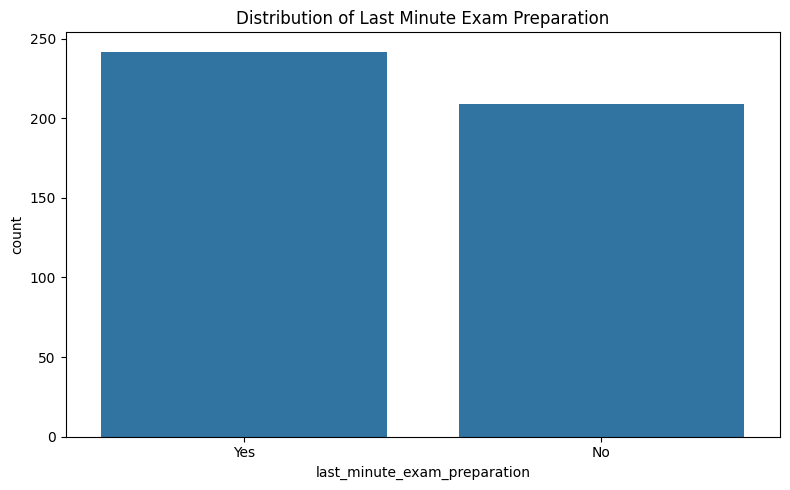

In [20]:
# Basic data exploration
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values by column:")
print(df.isnull().sum())

# Check target variable distribution
print("\nDistribution of 'last_minute_exam_preparation':")
print(df['last_minute_exam_preparation'].value_counts())
print(df['last_minute_exam_preparation'].value_counts(normalize=True))

# Visualize the distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='last_minute_exam_preparation', data=df)
plt.title('Distribution of Last Minute Exam Preparation')
plt.tight_layout()
plt.show()

In [22]:
# Remove timestamp as it's not useful for prediction
columns_to_drop = ['Timestamp'] + potential_leakage_columns

# Check if all columns exist before dropping
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df_cleaned = df.drop(columns=existing_columns_to_drop)

# Handle missing values
# First, check missing values percentage by column
missing_percentages = df_cleaned.isnull().mean().sort_values(ascending=False)
print("\nMissing values percentage by column:")
print(missing_percentages[missing_percentages > 0])

# Make sure 'last_minute_exam_preparation' has valid values
if 'last_minute_exam_preparation' not in df_cleaned.columns:
    raise ValueError("Target column 'last_minute_exam_preparation' not found in dataset")

# Check unique values in target variable
print("\nUnique values in target variable:")
print(df_cleaned['last_minute_exam_preparation'].unique())

# Ensure target variable has proper values
if df_cleaned['last_minute_exam_preparation'].isnull().any():
    print("Warning: Target variable contains missing values. Removing those rows...")
    df_cleaned = df_cleaned.dropna(subset=['last_minute_exam_preparation'])



Missing values percentage by column:
cgpa                                   0.022173
socio-economic_background              0.013304
use_of_time_management                 0.011086
procrastination_management_training    0.006652
dtype: float64

Unique values in target variable:
['Yes' 'No']


In [23]:
# Check if target variable needs encoding
try:
    y = df_cleaned['last_minute_exam_preparation'].map({'Yes': 1, 'No': 0})
    # Check if mapping created any NaN values (which would indicate unexpected values)
    if y.isnull().any():
        print("Warning: Target variable contains values other than 'Yes' or 'No'")
        # Get the unique values that aren't mapping correctly
        unexpected_values = df_cleaned.loc[y.isnull(), 'last_minute_exam_preparation'].unique()
        print(f"Unexpected values in target: {unexpected_values}")
        
        # Create a more flexible mapping
        value_mapping = {val: 1 if val in ['Yes', 'yes', 'Y', 'y', 'True', 'true', 1] 
                        else 0 for val in df_cleaned['last_minute_exam_preparation'].unique()}
        y = df_cleaned['last_minute_exam_preparation'].map(value_mapping)
except Exception as e:
    print(f"Error mapping target variable: {e}")
    # If mapping fails, try direct conversion (if target is already numeric)
    try:
        y = df_cleaned['last_minute_exam_preparation'].astype(int)
    except:
        raise ValueError("Cannot convert target variable to numeric format")


In [24]:
# Identify categorical and numerical columns
# First, exclude the target variable from X
X = df_cleaned.drop(columns=['last_minute_exam_preparation'])

# Check if there are any columns in X
if X.shape[1] == 0:
    raise ValueError("No feature columns found after preprocessing")

# Determine column types
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")


Categorical columns: ['study_year', 'socio-economic_background', 'assignment_delay_frequency', 'procrastination_reasons', 'assignment_submission_timing', 'stress_due_to_procrastination', 'study_hours_per_week', 'cgpa', 'use_of_time_management', 'procrastination_management_training', 'hours_spent_on_mobile_non_academic', 'study_session_distractions']
Numerical columns: []


In [26]:
# Create preprocessing pipelines for both numeric and categorical data
# Handle the case where there are no categorical columns
if len(categorical_cols) > 0 and len(numerical_cols) > 0:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numerical_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_cols)
        ])
elif len(numerical_cols) > 0:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numerical_cols)
        ])
elif len(categorical_cols) > 0:
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_cols)
        ])
else:
    raise ValueError("No feature columns found after preprocessing")


In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)



Training the model...
Making predictions...

Random Forest Model Evaluation:
Accuracy: 0.6017699115044248

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.48      0.53        52
           1       0.61      0.70      0.66        61

    accuracy                           0.60       113
   macro avg       0.60      0.59      0.59       113
weighted avg       0.60      0.60      0.60       113



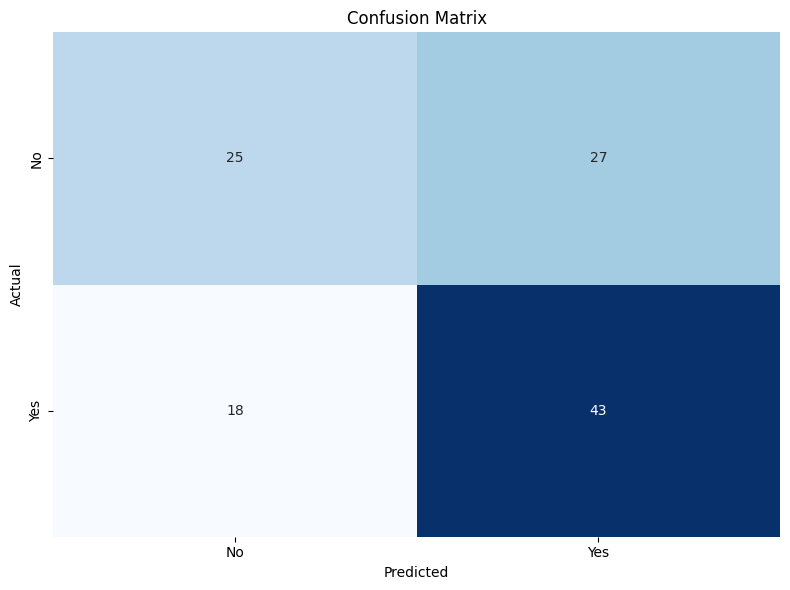

In [30]:
# Build a pipeline for the model with adjusted parameters
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

try:
    # Train the model
    print("\nTraining the model...")
    model_pipeline.fit(X_train, y_train)
    
    # Make predictions
    print("Making predictions...")
    y_pred = model_pipeline.predict(X_test)
    
    # Evaluate the model
    print("\nRandom Forest Model Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
               xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error during model training or evaluation: {e}")
    
    # Print more details about the data to help with debugging
    print("\nAdditional debugging information:")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_train data types: {X_train.dtypes}")
    print(f"y_train values: {y_train.value_counts()}")


In [31]:
# Feature Importance
# Function to safely extract feature importance
def get_feature_importance(pipeline, feature_names):
    try:
        preprocessor = pipeline.named_steps['preprocessor']
        classifier = pipeline.named_steps['classifier']
        
        # Get feature names after preprocessing
        all_feature_names = []
        
        # Process numerical features
        if len(numerical_cols) > 0 and ('num' in dict(preprocessor.transformers_)):
            all_feature_names.extend(numerical_cols)
        
        # Process categorical features
        if len(categorical_cols) > 0 and ('cat' in dict(preprocessor.transformers_)):
            ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
            if hasattr(ohe, 'get_feature_names_out'):
                cat_features = ohe.get_feature_names_out(categorical_cols)
                all_feature_names.extend(cat_features)
        
        # Get feature importances
        importances = classifier.feature_importances_
        
        # Ensure lengths match
        if len(all_feature_names) != len(importances):
            print(f"Warning: Feature names ({len(all_feature_names)}) and importances ({len(importances)}) have different lengths")
            all_feature_names = [f"Feature_{i}" for i in range(len(importances))]
        
        # Sort features by importance
        indices = np.argsort(importances)[::-1]
        
        # Return sorted feature names and importances
        return [all_feature_names[i] for i in indices], importances[indices]
    
    except Exception as e:
        print(f"Error extracting feature importance: {e}")
        return None, None


In [32]:
# Try to get feature importance - we need to make sure the model has been trained first
if 'model_pipeline' in locals() and hasattr(model_pipeline, 'named_steps') and hasattr(model_pipeline.named_steps.get('classifier', None), 'feature_importances_'):
    feature_names, importances = get_feature_importance(model_pipeline, X.columns)
    
    if feature_names is not None and importances is not None:
        # Plot top 15 features
        plt.figure(figsize=(12, 8))
        plt.title('Feature Importances')
        plt.barh(range(min(15, len(feature_names))), 
                importances[:15], align='center')
        plt.yticks(range(min(15, len(feature_names))), [str(x) for x in feature_names[:15]])
        plt.xlabel('Relative Importance')
        plt.tight_layout()
        plt.show()
    else:
        print("Could not extract feature importances")
else:
    print("Model not trained properly or doesn't support feature importance")


Error extracting feature importance: dictionary update sequence element #0 has length 3; 2 is required
Could not extract feature importances



Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.52      0.55        52
           1       0.63      0.69      0.66        61

    accuracy                           0.61       113
   macro avg       0.61      0.60      0.60       113
weighted avg       0.61      0.61      0.61       113


Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.44      0.49        52
           1       0.60      0.70      0.65        61

    accuracy                           0.58       113
   macro avg       0.58      0.57      0.57       113
weighted avg       0.58      0.58      0.58       113


Training Gradient Boosting...

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.58      0.60        52
           1       0.6

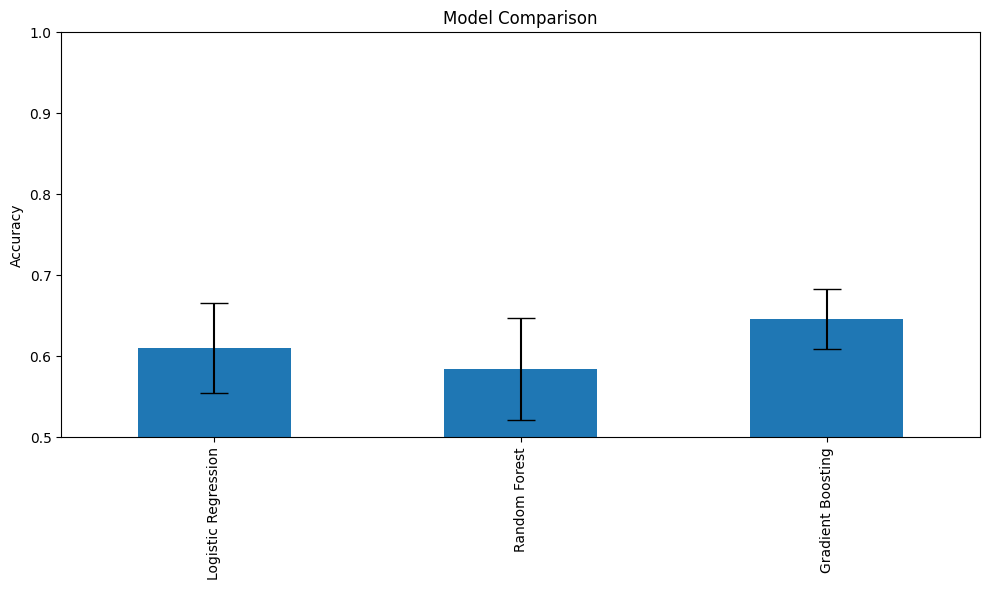


Tuning hyperparameters for Gradient Boosting...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters: {'classifier__learning_rate': 0.2, 'classifier__n_estimators': 50}
Best cross-validation accuracy: 0.5543

Tuned Model Evaluation:
Accuracy: 0.7787610619469026

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76        52
           1       0.79      0.80      0.80        61

    accuracy                           0.78       113
   macro avg       0.78      0.78      0.78       113
weighted avg       0.78      0.78      0.78       113



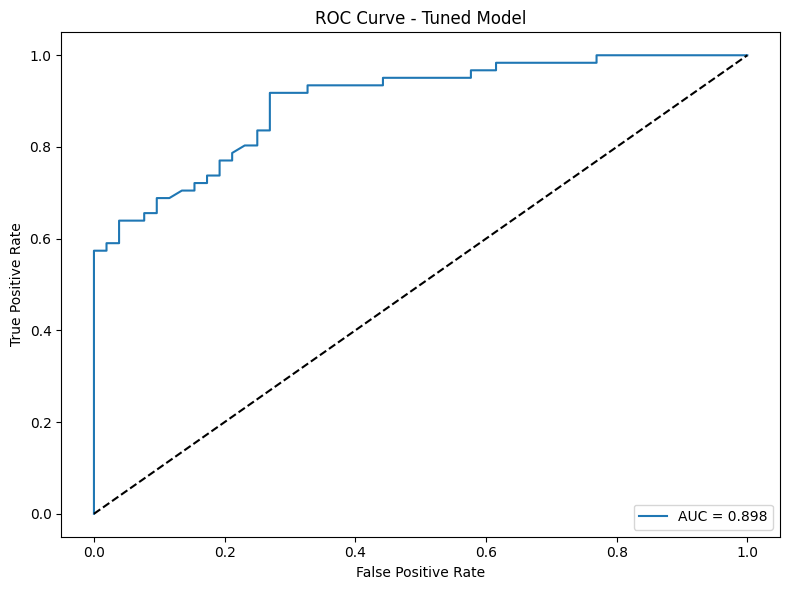


Model saved to 'last_minute_exam_prep_model.pkl'

CONCLUSIONS:
------------
1. The best performing model is Gradient Boosting with an accuracy of 0.6460
2. Key factors that predict last-minute exam preparation include:
Error extracting feature importance: dictionary update sequence element #0 has length 3; 2 is required
   Could not extract specific features due to preprocessing complexity.
3. This model can help educators identify students who might need additional support with study planning.


In [34]:
try:
    # Define the models to compare with more conservative parameters
    models = {
        'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42, solver='liblinear'),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    }
    
    # Compare models
    results = {}
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Perform cross-validation
        try:
            cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
            
            # Store results
            results[model_name] = {
                'CV Mean': cv_scores.mean(),
                'CV Std': cv_scores.std()
            }
            
            # Train on full training set
            pipe.fit(X_train, y_train)
            
            # Test on held-out test set
            y_pred = pipe.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_pred)
            
            results[model_name]['Test Accuracy'] = test_accuracy
            
            # Get classification report
            print(f"\n{model_name} Classification Report:")
            print(classification_report(y_test, y_pred))
        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")
    
    # Create a comparison table
    results_df = pd.DataFrame(results).T
    print("\nModel Comparison:")
    print(results_df)
    
    # Visualize model comparison
    if results_df.shape[0] > 0:
        plt.figure(figsize=(10, 6))
        results_df['Test Accuracy'].plot(kind='bar', yerr=results_df['CV Std'], capsize=10)
        plt.title('Model Comparison')
        plt.ylabel('Accuracy')
        plt.ylim(0.5, 1)
        plt.tight_layout()
        plt.show()
    
    # HYPERPARAMETER TUNING
    # --------------------
    if len(results) > 0:
        # Get the best performing model
        best_model_name = results_df['Test Accuracy'].idxmax()
        print(f"\nTuning hyperparameters for {best_model_name}...")
        
        # Define simpler parameter grid for faster tuning
        if best_model_name == 'Random Forest':
            param_grid = {
                'classifier__n_estimators': [50, 100],
                'classifier__max_depth': [10, 20]
            }
            base_model = RandomForestClassifier(random_state=42)
        elif best_model_name == 'Gradient Boosting':
            param_grid = {
                'classifier__n_estimators': [50, 100],
                'classifier__learning_rate': [0.1, 0.2]
            }
            base_model = GradientBoostingClassifier(random_state=42)
        else:  # Logistic Regression
            param_grid = {
                'classifier__C': [0.1, 1, 10],
                'classifier__penalty': ['l2']
            }
            base_model = LogisticRegression(max_iter=2000, random_state=42, solver='liblinear')
        
        # Create pipeline with the best model
        best_pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', base_model)
        ])
        
        # Grid search for hyperparameter tuning with fewer options for speed
        grid_search = GridSearchCV(
            best_pipe,
            param_grid,
            cv=3,  # Reduce CV folds for speed
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        
        try:
            # Fit grid search
            grid_search.fit(X, y)
            
            # Best parameters and score
            print(f"\nBest parameters: {grid_search.best_params_}")
            print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
            
            # Evaluate the tuned model on the test set
            best_model = grid_search.best_estimator_
            y_pred_best = best_model.predict(X_test)
            
            print("\nTuned Model Evaluation:")
            print("Accuracy:", accuracy_score(y_test, y_pred_best))
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred_best))
            
            # ROC Curve for the best model
            try:
                y_prob_best = best_model.predict_proba(X_test)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_prob_best)
                roc_auc = auc(fpr, tpr)
                
                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve - Tuned Model')
                plt.legend(loc='lower right')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Could not generate ROC curve: {e}")
            
            # SAVE THE MODEL
            import joblib
            
            # Save the best model
            joblib.dump(best_model, 'last_minute_exam_prep_model.pkl')
            print("\nModel saved to 'last_minute_exam_prep_model.pkl'")
            
            # CONCLUSIONS
            print("\nCONCLUSIONS:")
            print("------------")
            print(f"1. The best performing model is {best_model_name} with an accuracy of {results_df.loc[best_model_name, 'Test Accuracy']:.4f}")
            print("2. Key factors that predict last-minute exam preparation include:")
            
            # Try to get feature importance from the best model
            if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
                feature_names, importances = get_feature_importance(best_model, X.columns)
                if feature_names is not None:
                    for i in range(min(5, len(feature_names))):
                        print(f"   - {feature_names[i]}")
                else:
                    print("   Could not extract specific features due to preprocessing complexity.")
            else:
                print("   Could not extract specific features due to model type.")
                
            print("3. This model can help educators identify students who might need additional support with study planning.")
            
        except Exception as e:
            print(f"Error during hyperparameter tuning: {e}")
    else:
        print("No models were successfully trained for hyperparameter tuning.")
        
except Exception as e:
    print(f"Error during model comparison: {e}")